# Prereq
This notebook was developed on RAPIDS 21.08. Please use conda env or container from https://rapids.ai/start.html#get-rapids

# Setup
Please execute the following cell the first time to install packages and download data.

In [24]:
#!pip install biopython
#!wget https://zenodo.org/record/2543724/files/pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz?download=1 -O pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz
#!zstd -d pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz

In [25]:
import cudf
from Bio import Entrez
from Bio.Entrez.Parser import ListElement
import matplotlib.pyplot as plt
import pandas as pd

Setup

In [26]:
# Please replace your email address here
Entrez.email = "PLEASE ENTER YOUR EMAIL HERE"
data_file = 'data_v2.tsv'

In [27]:
# This list is obtained from
# Chemformer - A Pre-Trained Transformer for Computational Chemistry - Supplementary_info_supplement_1
gene_list = ["ABL1", "ACHE", "ADAM17", "ADORA2A", "ADORA2B", "ADORA3", "ADRA1A", "ADRA1D", 
             "ADRB1", "ADRB2", "ADRB3", "AKT1", "AKT2", "ALK", "ALOX5", "AR", "AURKA", 
             "AURKB", "BACE1", "CA1", "CA12", "CA2", "CA9", "CASP1", "CCKBR", "CCR2", 
             "CCR5", "CDK1", "CDK2", "CHEK1", "CHRM1", "CHRM2", "CHRM3", "CHRNA7", "CLK4", 
             "CNR1", "CNR2", "CRHR1", "CSF1R", "CTSK", "CTSS", "CYP19A1", "DHFR", "DPP4", 
             "DRD1", "DRD3", "DRD4", "DYRK1A", "EDNRA", "EGFR", "EPHX2", "ERBB2", "ESR1", 
             "ESR2", "F10", "F2", "FAAH", "FGFR1", "FLT1", "FLT3", "GHSR", "GNRHR", "GRM5", 
             "GSK3A", "GSK3B", "HDAC1", "HPGD", "HRH3", "HSD11B1", "HSP90AA1", "HTR2A", 
             "HTR2C", "HTR6", "HTR7", "IGF1R", "INSR", "ITK", "JAK2", "JAK3", "KCNH2", 
             "KDR", "KIT", "LCK", "MAOB", "MAPK14", "MAPK8", "MAPK9", "MAPKAPK2", "MC4R", 
             "MCHR1", "MET", "MMP1", "MMP13", "MMP2", "MMP3", "MMP9", "MTOR", "NPY5R", 
             "NR3C1", "NTRK1", "OPRD1", "OPRK1", "OPRL1", "OPRM1", "P2RX7", "PARP1", "PDE5A", 
             "PDGFRB", "PGR", "PIK3CA", "PIM1", "PIM2", "PLK1", "PPARA", "PPARD", "PPARG", 
             "PRKACA", "PRKCD", "PTGDR2", "PTGS2", "PTPN1", "REN", "ROCK1", "ROCK2", "S1PR1", 
             "SCN9A", "SIGMAR1", "SLC6A2", "SLC6A3", "SRC", "TACR1", "TRPV1", "VDR"]

In [28]:
def get_ec_num(rec):
    """
    Helper function to extract EC number from record
    """
    ecs = []

    if isinstance(rec, ListElement):
        for r in rec:
            ecs.extend(get_ec_num(r))
    elif 'Gene-commentary_label' in rec and rec['Gene-commentary_label'] == 'EC':
        ecs.append(rec['Gene-commentary_text'])
    elif 'Gene-commentary_comment' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_comment']))
    elif 'Gene-commentary_products' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_products']))

    return ecs

In [29]:
# Load data. Here only required fields are loaded. Please use the wget command 
# in the first cell to download data. Please extract it before using it.
data = cudf.read_csv(data_file,
                     delimiter='\t',
                     usecols=['Entrez_ID', 'pXC50'])

In [30]:
# Set Entrez_ID as index for ease
data['Cnt'] = data['Entrez_ID']
data_indexed = data.set_index('Entrez_ID')

# Group by Entrez_ID and compute data for each Entrez_ID
entrez_id_count = data_indexed.groupby(level='Entrez_ID')

count_df = entrez_id_count.count()
count_df = count_df.sort_values('Cnt', ascending=False)
count_df['pXC50_min'] = entrez_id_count.pXC50.min()
count_df['pXC50_max'] = entrez_id_count.pXC50.max()
count_df.drop('pXC50', axis=1, inplace=True)
summary = count_df.to_pandas()
# summary = summary.iloc[:10]
summary.head()


,Cnt,pXC50_min,pXC50_max
Entrez_ID,,,
3417,466456,4.00,8.74000
1080,456865,3.31,8.46000
4780,409655,4.01,9.30000
2740,409127,4.00,8.03621
1814,405348,3.10,11.55280


Following code uses Entrez_ID to query NCBI DB to fetch EC number. This may take 
a while to fetch all EC numbers.

In [31]:
# Fetch EC numbers using BioPython
all_ecs = []
names = []
gene_code = []
for entrez_id in summary.index.values:
    handle = Entrez.efetch(db="gene", id=entrez_id, retmode = "xml")
    recs = Entrez.read(handle)
    ecs = []
    for rec in recs:
        for locus in rec['Entrezgene_locus']:
            ecs.extend(get_ec_num(locus))

    ecs = list(set(ecs))
    all_ecs.append(str(ecs))
    names.append(recs[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc'])
    gene_code.append(recs[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_locus'])

summary['EC'] = all_ecs
summary['name'] = names
summary['gene_code'] = gene_code

# Filter out records with gene_list from 
summary = summary[summary.gene_code.isin(gene_list)]
summary = summary[['gene_code', 'Entrez_ID', 'name', 'EC', 'Cnt', 'pXC50_min',	'pXC50_max']]
summary.to_csv('summary.csv')
summary.head()

,Cnt,pXC50_min,pXC50_max,EC,name,gene_code
Entrez_ID,,,,,,
1814,405348,3.10,11.5528,[],dopamine receptor D3,DRD3
7421,391988,3.21,11.7000,[],vitamin D receptor,VDR
6868,367067,3.74,10.5900,['3.4.24.86'],ADAM metallopeptidase domain 17,ADAM17
1128,357391,2.21,12.0000,[],cholinergic receptor muscarinic 1,CHRM1
1812,357254,3.40,10.0000,[],dopamine receptor D1,DRD1


Plot the histgram visializing density of count.

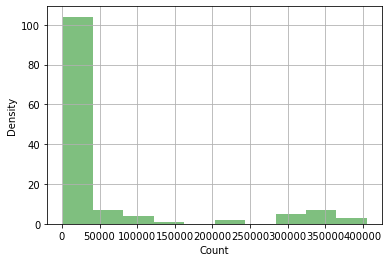

In [36]:
summary = pd.read_csv('summary.csv')
plt.hist(summary['Cnt'].values, 10, facecolor='g', alpha=0.50)
plt.xlabel('Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()